### Decoding from fMRI data

In this notebook we will use the Haxby et al. data that were prepared in the Data Setup notebook to perform classification.



In [47]:
import os
import h5py
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut, KFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold
import warnings
from utils import get_subject_runs
import torch
import nilearn
from sklearn.preprocessing import StandardScaler
from nilearn.maskers import NiftiMasker
import nilearn.plotting
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from nilearn.decoding.searchlight import search_light
from sklearn import neighbors


base_dir = '/Users/poldrack/data_unsynced/ds000105'
h5_file = os.path.join(base_dir, 'derivatives/cleaned/haxby_data_cleaned.h5')

device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using device {device}')

Using device mps


### Load the data



In [39]:
def get_subject_data(
    subject,
    h5_file,
    bids_dir,
    data_key='vtmaskdata',
    condmeans=False,
    condition_subset=None,
):
    assert data_key in ['braindata', 'vtmaskdata', 'difumodata']
    meanstr = 'mean_' if condmeans else ''
    runs = get_subject_runs(subject, bids_dir)
    X, metadata_df = None, None

    with h5py.File(h5_file, 'r') as hf:
        for run in runs:
            if X is None:
                X = hf[f'sub-{subject}/run-{run}/{meanstr + data_key}'][:]
            else:
                X = np.vstack(
                    (X, hf[f'sub-{subject}/run-{run}/{meanstr + data_key}'][:])
                )
            if metadata_df is None:
                conditions = [
                    i.decode('utf-8')
                    for i in hf[
                        f'sub-{subject}/run-{run}/{meanstr}conditions'
                    ][:]
                ]
                metadata_df = pd.DataFrame(
                    {'conditions': conditions, 'run': run}
                )
            else:
                conditions = [
                    i.decode('utf-8')
                    for i in hf[
                        f'sub-{subject}/run-{run}/{meanstr}conditions'
                    ][:]
                ]
                metadata_df = pd.concat(
                    [
                        metadata_df,
                        pd.DataFrame({'conditions': conditions, 'run': run}),
                    ]
                )
    if condition_subset is not None:
        metadata_df = metadata_df[
            metadata_df['conditions'].isin(condition_subset)
        ]
        X = X[metadata_df.index]
    assert X.shape[0] == metadata_df.shape[0]
    return X, metadata_df


X, metadata_df = get_subject_data(
    1, h5_file, base_dir, condmeans=True, data_key='vtmaskdata'
)
print(X.shape)
metadata_df.conditions.unique()

(96, 1404)


array(['bottle', 'cat', 'chair', 'face', 'house', 'scissors',
       'scrambledpix', 'shoe'], dtype=object)

### Run decoding model

Use a leave-one-run-out crossvalidation scheme

In [40]:

# leave one run out cross validation


def run_cv_subject(
    data,
    metadata_df,
    nfeatures=None,
    shuffle=False,
    varthresh=None,
    clf=None,
    suppress_warnings=False,
    standardize=True,
):
    """
    Perform cross-validation for decoding analysis.

    Parameters:
    - data_df (pandas.DataFrame): The input data frame containing the features and labels.
    - nfeatures (int): The number of features to select using ANOVA. Default is 1000, or None to disable.
    - shuffle_y (bool): Whether to shuffle the labels. Default is False
    - varthresh (float): The variance threshold for feature selection. Default is 0, or None to disable.
    - clf (sklearn classifier): The classifier to use. Default is None, which uses a Support Vector Machine

    Returns:
    - accs (list): A list of accuracy scores for each cross-validation fold.
    """
    if clf is None:
        clf = SGDClassifier()   # by default is like SVM with l2 regularization

    # Suppress warnings from scikit-learn
    if suppress_warnings:
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)

    # Leave one run out cross-validation
    logo = LeaveOneGroupOut()
    assert data.shape[0] == metadata_df.shape[0]

    if shuffle:
        metadata_df.conditions = np.random.permutation(metadata_df.conditions)

    # perform variance thresholding with default of zero
    if varthresh is not None:
        vt = VarianceThreshold(threshold=varthresh)
        data = vt.fit_transform(data)

    accs = []
    coefs = None
    for train_index, test_index in logo.split(data, groups=metadata_df.run):
        train_X = data[train_index]
        assert train_X.shape[0] == len(train_index)
        assert train_X.shape[1] == data.shape[1]
        test_X = data[test_index]
        train_y = metadata_df.conditions.iloc[train_index]
        test_y = metadata_df.conditions.iloc[test_index]

        if standardize:
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X)
            test_X = scaler.transform(test_X)

        if nfeatures is not None:
            # Feature selection based on training data only
            selector = SelectKBest(score_func=f_classif, k=nfeatures)
            train_data_selected = selector.fit_transform(train_X, train_y)
            test_data_selected = selector.transform(test_X)
        else:
            train_data_selected = train_X
            test_data_selected = test_X

        clf.fit(train_data_selected, train_y)
        if hasattr(clf, 'coef_'):
            if coefs is None:
                coefs = clf.coef_
            else:

                coefs += clf.coef_
        acc = accuracy_score(test_y, clf.predict(test_data_selected))
        accs.append(acc)
    if coefs is not None:
        mean_coefs = coefs / len(accs)
    else:
        mean_coefs = None
    return accs, mean_coefs


def get_runs_from_hf(hf, subject):
    runs = [int(i.split('-')[-1]) for i in hf[subject].keys()]
    runs.sort()
    return runs


def run_cv(
    clf=None,
    shuffle=False,
    nfeatures=None,
    varthresh=None,
    data_key='braindata',
    condmeans=False,
    condition_subset=None,
):
    if clf is None:
        clf = SGDClassifier()
    print(f'Running cross-validation with {clf}')
    if nfeatures is not None:
        print(f'Selecting best {nfeatures} features: ')
    if varthresh is not None:
        print(f'Performing variance thresholding with threshold {varthresh}')
    if shuffle:
        print('Including shuffled data')
    accs = {}
    coefs = {}

    # would usually run this many more times for shuffled data
    nshuffles = 1
    shuffle_vals = [False, True] if shuffle else [False]

    for subject in range(1, 7):
        subdata, metadata_df = get_subject_data(
            subject,
            h5_file,
            base_dir,
            condmeans=condmeans,
            data_key=data_key,
            condition_subset=condition_subset,
        )
        print(f'Subject {subject}')
        print(f'data shape: {subdata.shape}')
        accs[subject] = {}
        for shuffle_y in shuffle_vals:
            shuffled_string = 'shuffled' if shuffle_y else 'orig'
            nruns = nshuffles if shuffle_y else 1
            accs[subject][shuffled_string] = 0
            for i in range(nruns):
                acc_, coef_ = run_cv_subject(
                    subdata,
                    metadata_df,
                    nfeatures=nfeatures,
                    shuffle=shuffle_y,
                    varthresh=varthresh,
                    clf=clf,
                )
                if shuffle_y is False:
                    coefs[subject] = coef_
                accs[subject][shuffled_string] += np.mean(acc_)
            accs[subject][shuffled_string] /= nshuffles
            print(
                f'Mean accuracy ({shuffled_string}): {np.mean(accs[subject][shuffled_string]):.03}'
            )

        print('')
    return accs, coefs


# run crossvalidation across subjects with default settings
# need to run without thresholding or feature selection to get the full set of coefs
data_key = 'vtmaskdata'
condmeans = True
condition_subset = None   # ['face', 'house', 'cat']

accs, coefs = run_cv(
    shuffle=False,
    data_key=data_key,
    condmeans=condmeans,
    varthresh=None,
    nfeatures=None,
    condition_subset=condition_subset,
)

results_df = pd.DataFrame({'SGD_l2': [accs[i]['orig'] for i in accs.keys()]})
results_df

Running cross-validation with SGDClassifier()
Subject 1
data shape: (96, 1404)
Mean accuracy (orig): 0.771

Subject 2
data shape: (96, 1114)
Mean accuracy (orig): 0.677

Subject 3
data shape: (96, 701)
Mean accuracy (orig): 0.708

Subject 4
data shape: (96, 1623)
Mean accuracy (orig): 0.677

Subject 5
data shape: (88, 893)
Mean accuracy (orig): 0.886

Subject 6
data shape: (96, 746)
Mean accuracy (orig): 0.667



,SGD_l2
0,0.770833
1,0.677083
2,0.708333
3,0.677083
4,0.886364
5,0.666667


#### Visualizing the coefficients


(8, 1404)


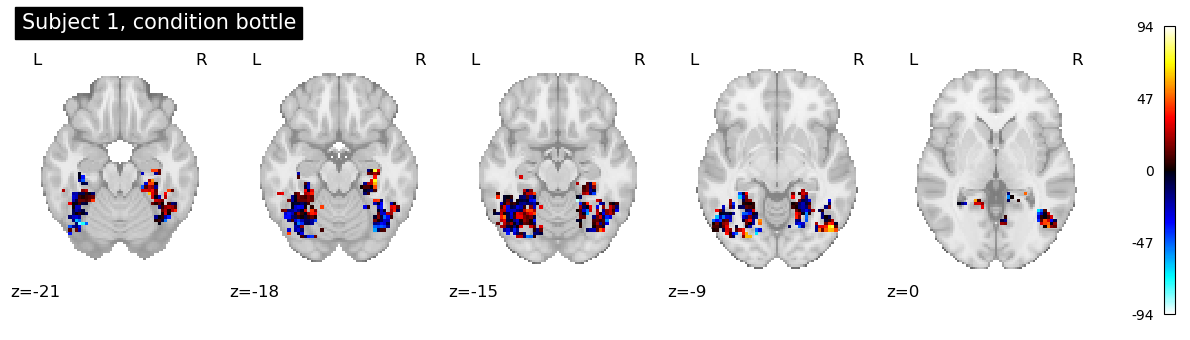

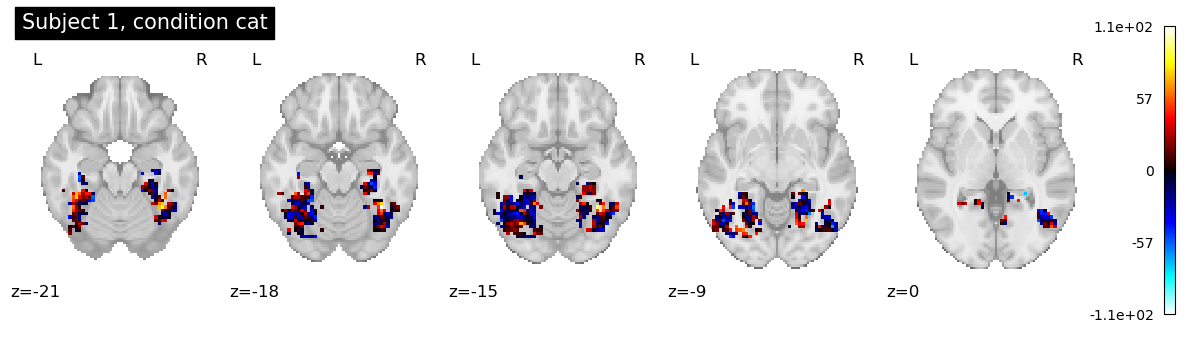

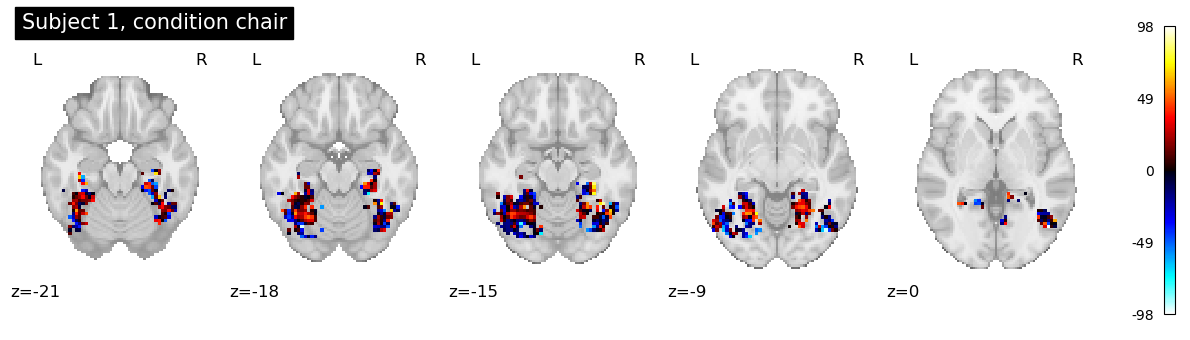

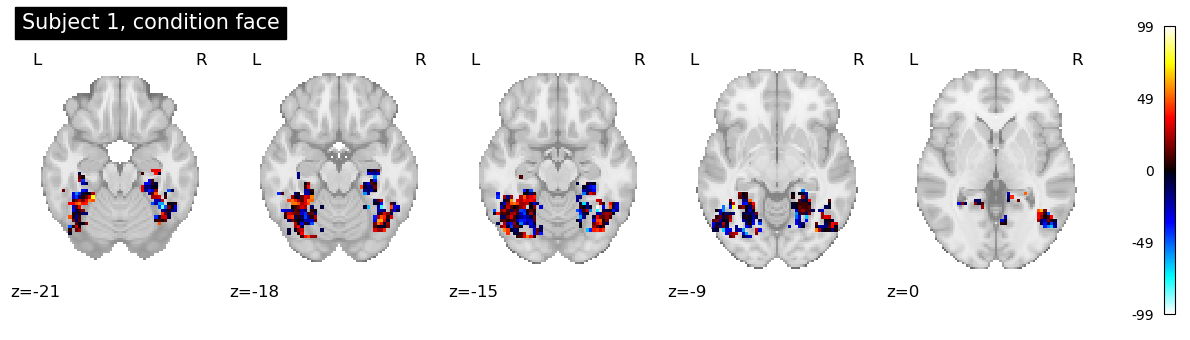

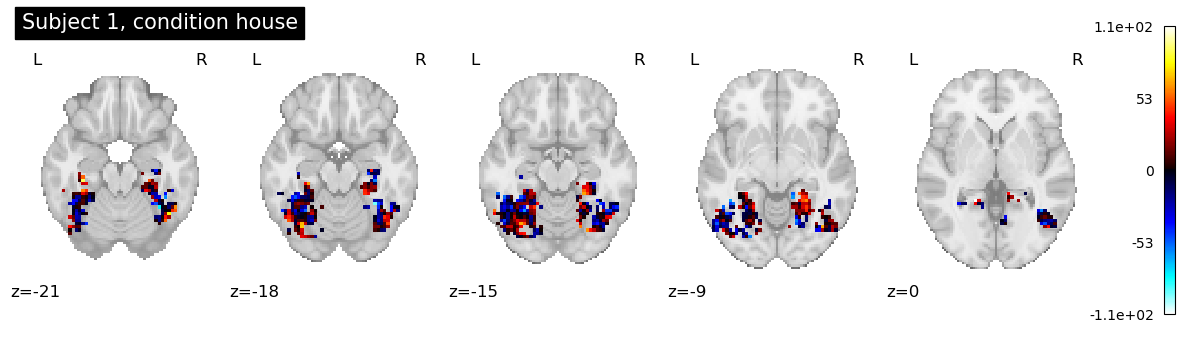

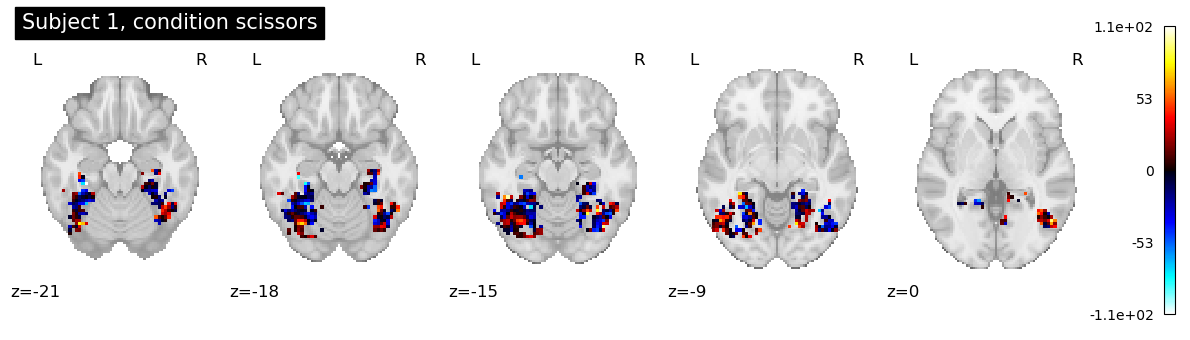

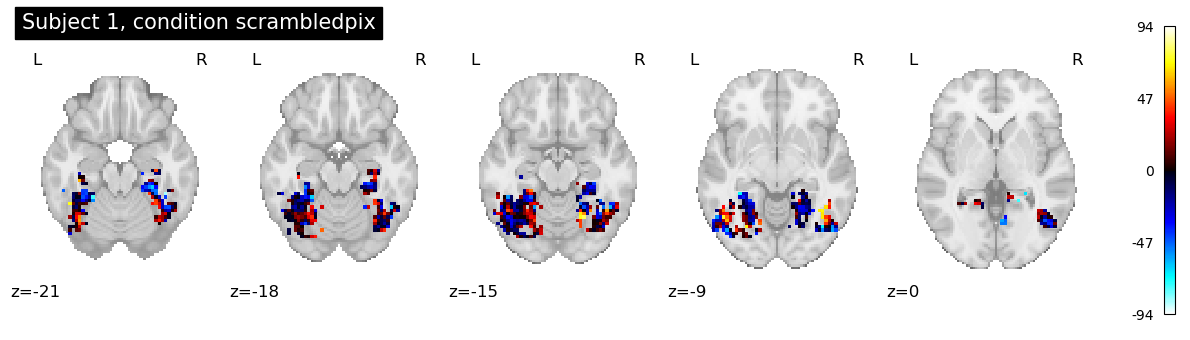

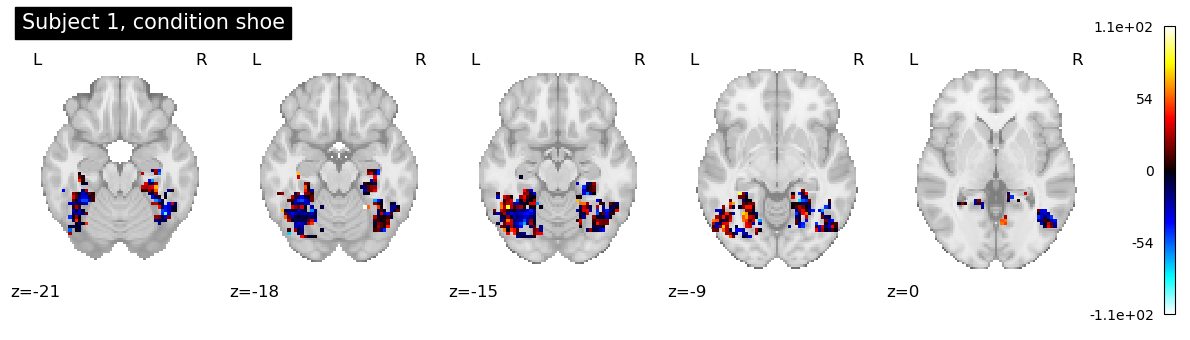

In [41]:
def get_subject_vt_mask(subject, vtmask_dir, res=3):
    vt_mask_file = os.path.join(
        vtmask_dir,
        f'sub-{subject}_mask4vt_space-MNI152NLin2009cAsym_res-{res}.nii.gz',
    )
    return nib.load(vt_mask_file)


def visualize_coefs(coefs, conditions, vtmask_dir):

    # plot the mean coefficients
    for subject in range(1, 2):
        mask_img = get_subject_vt_mask(subject, vtmask_dir)
        masker = NiftiMasker(mask_img)
        masker.fit()
        print(coefs[subject].shape)
        coef_img = masker.inverse_transform(coefs[subject])
        for c in range(coefs[subject].shape[0]):
            nilearn.plotting.plot_stat_map(
                coef_img.slicer[..., c],
                display_mode='z',
                cut_coords=[-21, -18, -15, -9, 0],
                title=f'Subject {subject}, condition {conditions[c]}',
            )


if condition_subset is None:
    conditions = metadata_df.conditions.unique().tolist()
else:
    conditions = condition_subset
vtmask_dir = os.path.join(base_dir, 'derivatives/vtmasks')
visualize_coefs(coefs, conditions, vtmask_dir)

### Effect of different regularization schemes

In the previous model, we used a support vector machine with an L2 penalty, which penalizes the sum of squared weights. We can also look at the effect using a different penalty, namely an L1 penalty, which penalizes based on the sum of absolute weights, and leads in general to sparser solutions (more zero weights).

We can set the `LinearSVC` classifier to use L1 penalization.

Running cross-validation with SGDClassifier(alpha=0.01, penalty='l1')
Subject 1
data shape: (96, 1404)
Mean accuracy (orig): 0.74

Subject 2
data shape: (96, 1114)
Mean accuracy (orig): 0.677

Subject 3
data shape: (96, 701)
Mean accuracy (orig): 0.667

Subject 4
data shape: (96, 1623)
Mean accuracy (orig): 0.573

Subject 5
data shape: (88, 893)
Mean accuracy (orig): 0.83

Subject 6
data shape: (96, 746)
Mean accuracy (orig): 0.646

(8, 1404)


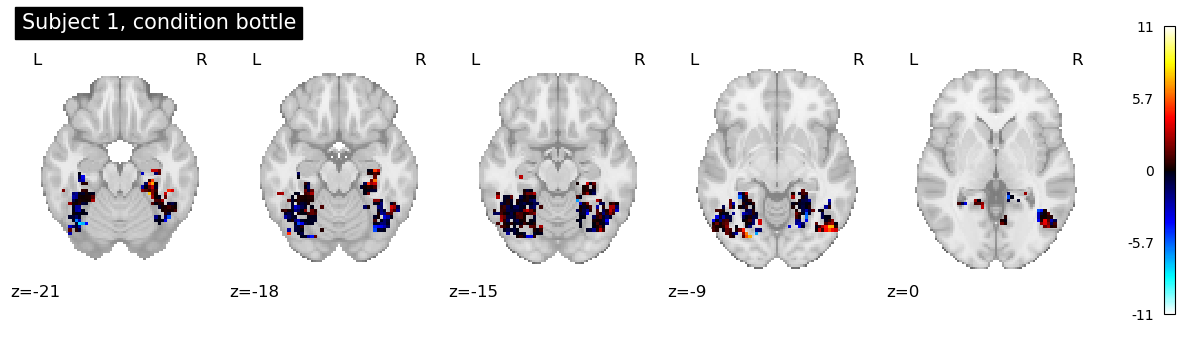

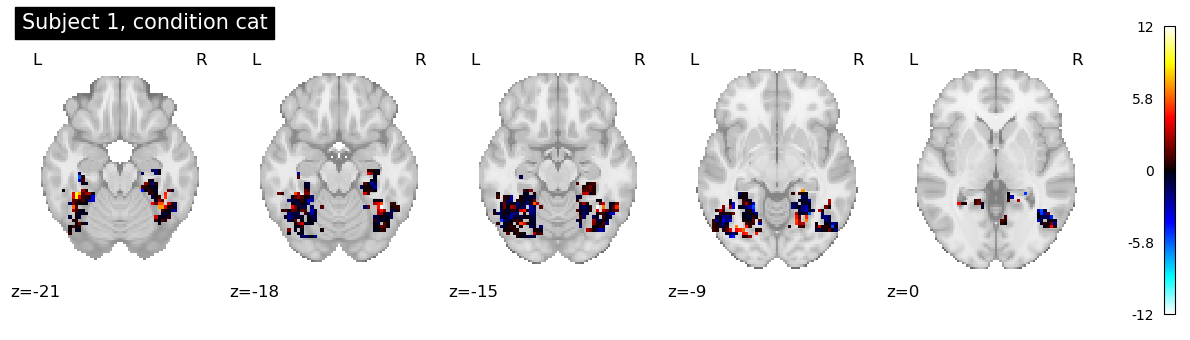

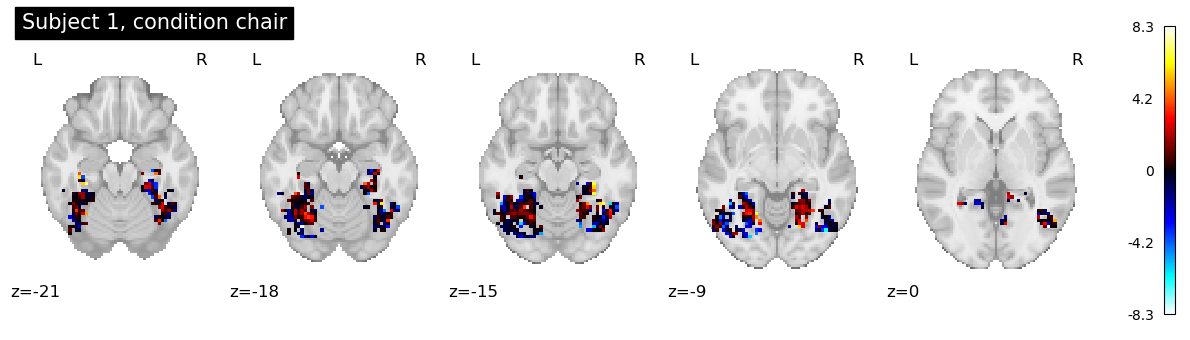

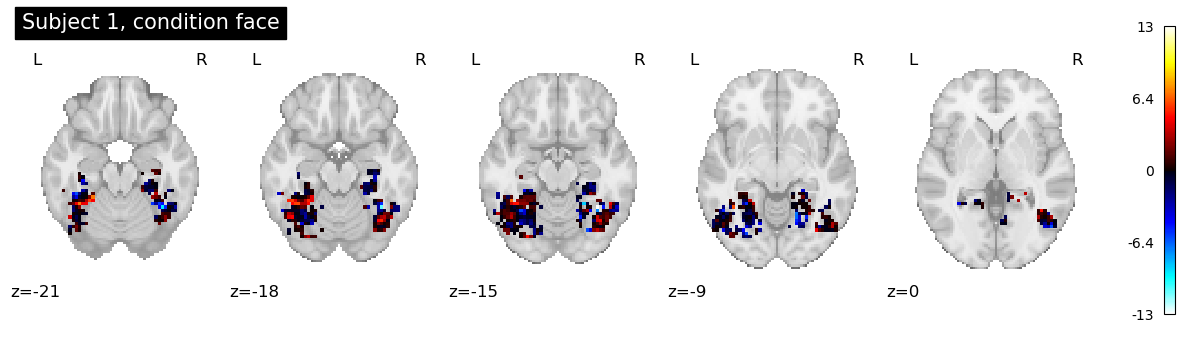

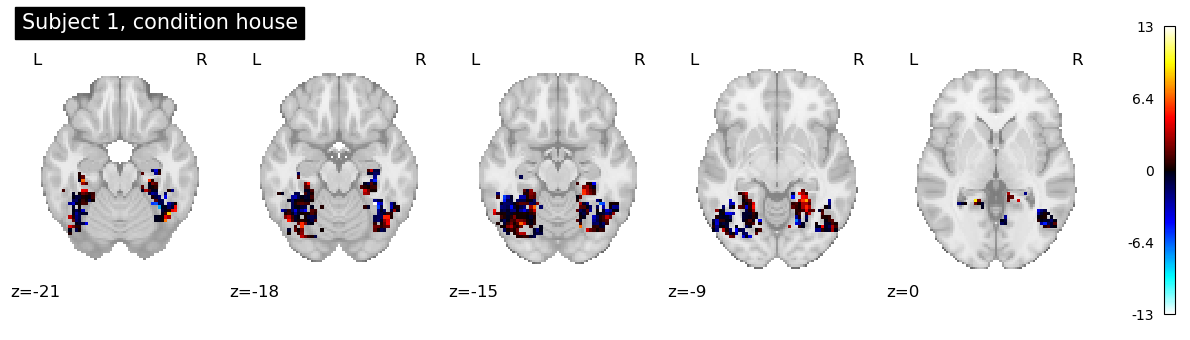

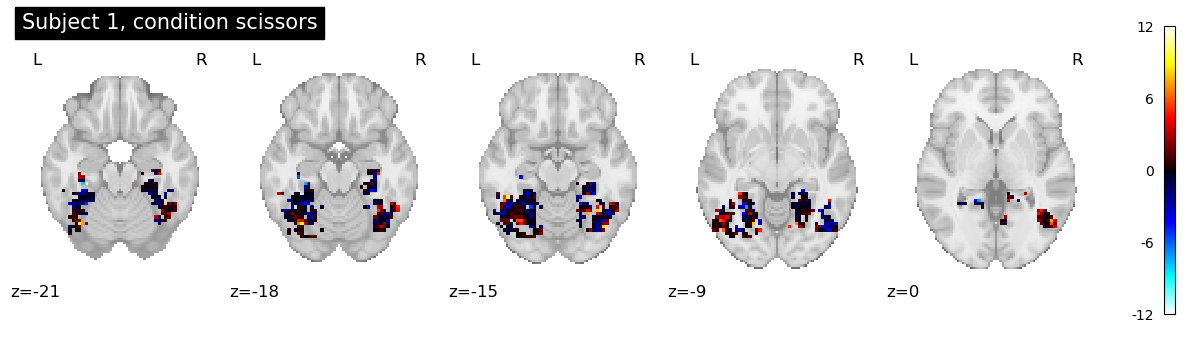

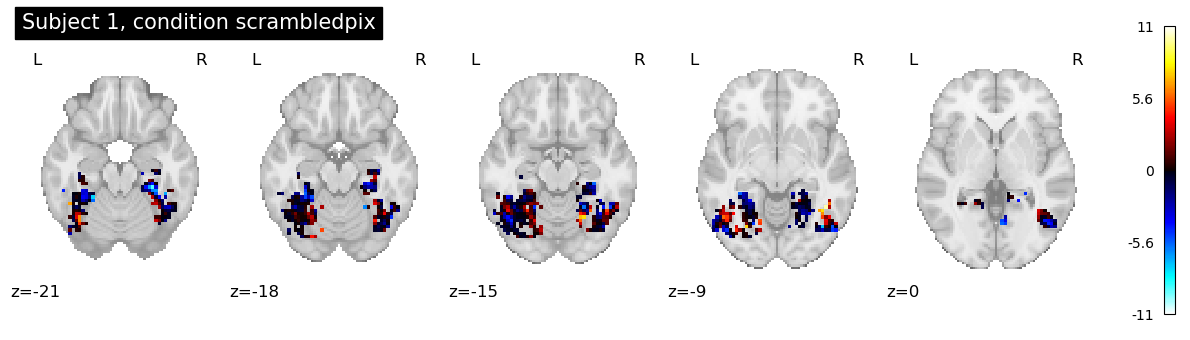

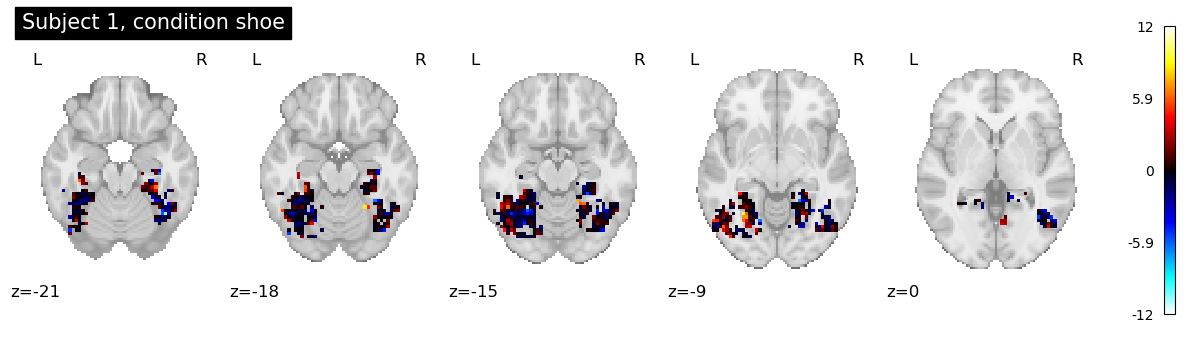

In [42]:
accs_L1, coefs_L1 = run_cv(
    shuffle=False,
    data_key=data_key,
    condmeans=condmeans,
    clf=SGDClassifier(penalty='l1', alpha=0.01),
    varthresh=None,
    nfeatures=None,
)
results_df['SGD_l1'] = [accs_L1[i]['orig'] for i in accs_L1.keys()]
visualize_coefs(coefs_L1, conditions, vtmask_dir)

### Multi-layer perceptron

Now we will use a nonlinear model: a multi-layer perceptron, which has a single layer of modifiable weights.  We use a single hidden layer with 100 units.

In [43]:

accs_MLP, coefs_MLP = run_cv(
    shuffle=False,
    data_key=data_key,
    condmeans=condmeans,
    clf=MLPClassifier(hidden_layer_sizes=(128), max_iter=500),
    varthresh=None,
    nfeatures=None,
)
results_df['MLP'] = [accs_MLP[i]['orig'] for i in accs_MLP.keys()]

Running cross-validation with MLPClassifier(hidden_layer_sizes=128, max_iter=500)
Subject 1
data shape: (96, 1404)
Mean accuracy (orig): 0.781

Subject 2
data shape: (96, 1114)
Mean accuracy (orig): 0.76

Subject 3
data shape: (96, 701)
Mean accuracy (orig): 0.656

Subject 4
data shape: (96, 1623)
Mean accuracy (orig): 0.635

Subject 5
data shape: (88, 893)
Mean accuracy (orig): 0.875

Subject 6
data shape: (96, 746)
Mean accuracy (orig): 0.719



<Axes: >

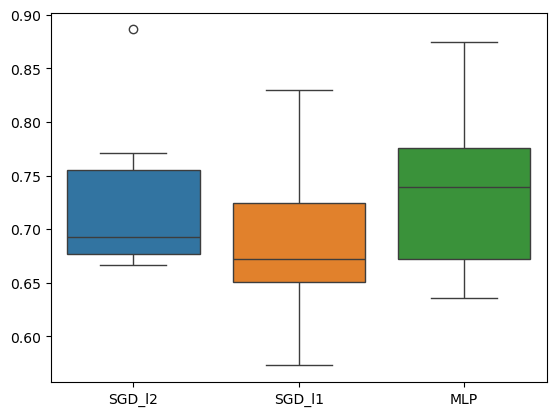

In [44]:
import seaborn as sns

sns.boxplot(data=results_df)

### Searchlight decoding using surface data

Based on [nilearn tutorial](https://nilearn.github.io/stable/auto_examples/02_decoding/plot_haxby_searchlight_surface.html)

In [129]:
def get_subject_surface_data(
    subject,
    h5_file,
    bids_dir,
    condmeans=True,
    hemispheres=None,
    condition_subset=None,
):
    if hemispheres is None:
        hemispheres = ['L', 'R']
    # replace left/right with L/R
    hemispheres = [h if h in ['L', 'R'] else h[0].upper() for h in hemispheres]
    meanstr = 'mean_' if condmeans else ''
    runs = get_subject_runs(subject, bids_dir)
    X, metadata_df = None, None

    with h5py.File(h5_file, 'r') as hf:

        for run in runs:
            data = [hf[f'sub-{subject}/run-{run}/{meanstr + h}'][:] for h in hemispheres]
            combined_data = np.hstack((
                  data
                ))
            if X is None:
                X = combined_data
            else:
                X = np.vstack(
                    (X, combined_data)
                )
            if metadata_df is None:
                conditions = [
                    i.decode('utf-8')
                    for i in hf[
                        f'sub-{subject}/run-{run}/{meanstr}conditions'
                    ][:]
                ]
                metadata_df = pd.DataFrame(
                    {'conditions': conditions, 'run': run}
                )
            else:
                conditions = [
                    i.decode('utf-8')
                    for i in hf[
                        f'sub-{subject}/run-{run}/{meanstr}conditions'
                    ][:]
                ]
                metadata_df = pd.concat(
                    [
                        metadata_df,
                        pd.DataFrame({'conditions': conditions, 'run': run}),
                    ]
                )
    if condition_subset is not None:
        metadata_df = metadata_df[
            metadata_df['conditions'].isin(condition_subset)
        ]
        X = X[metadata_df.index]
    assert X.shape[0] == metadata_df.shape[0]
    return X, metadata_df


h5_surface_file = os.path.join(base_dir, 'derivatives/cleaned/haxby_surface_data_cleaned.h5')
X, metadata_df = get_subject_surface_data(
    1, h5_surface_file, base_dir, condmeans=True, 
    hemispheres=['L'],
   # condition_subset=["face", "house"]
)
print(X.shape)
metadata_df.conditions.unique()

(96, 10242)


array(['bottle', 'cat', 'chair', 'face', 'house', 'scissors',
       'scrambledpix', 'shoe'], dtype=object)

In [130]:

def searchlight_adjacency(hemi, radius=3, surf='infl'):
    assert hemi in ['left', 'right']
    fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh="fsaverage5")
    infl_mesh = fsaverage[f"{surf}_{hemi}"]
    coords, _ = nilearn.surface.load_surf_mesh(infl_mesh)
    nn = neighbors.NearestNeighbors(radius=radius)
    return nn.fit(coords).radius_neighbors_graph(coords).tolil()

def run_searchlight(subject, h5_surface_file, base_dir,
                    radius=3,
                    condition_subset=None,
                    condmeans=True):

    scores = {}

    for hemis in ['left', 'right']:
    
        adjacency = searchlight_adjacency(hemis, radius)

        X, metadata_df = get_subject_surface_data(
            subject, h5_surface_file, base_dir, 
            condmeans=condmeans, 
            hemispheres=[hemis],
            condition_subset=condition_subset
        )

        # Simple linear estimator preceded by a normalization step
        estimator = make_pipeline(StandardScaler(), SGDClassifier())

        # Define cross-validation scheme
        # we can use this to do leave-one-run-out with shuffle turned off since there are 12 runs
        # in order in the data, so each fold leaves out two runs
        cv = KFold(n_splits=6, shuffle=False)

        # Cross-validated search light
        scores[hemis] = search_light(X, metadata_df.conditions.values, estimator, adjacency, cv=cv, n_jobs=12)
    return scores


['L']
['R']
['L']
['R']
['L']
['R']
['L']
['R']
['L']
['R']
['L']
['R']


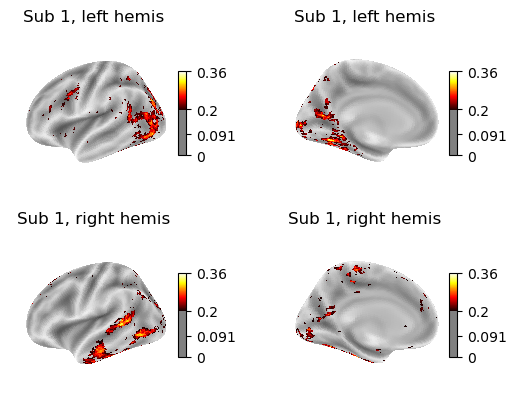

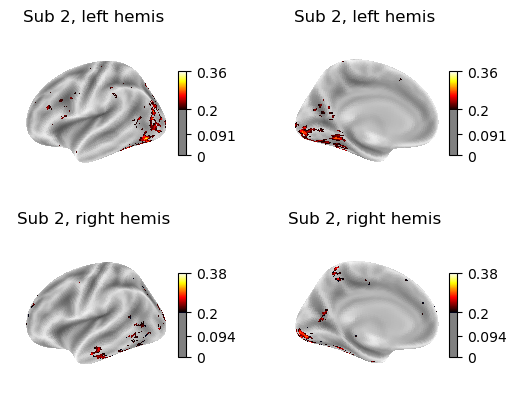

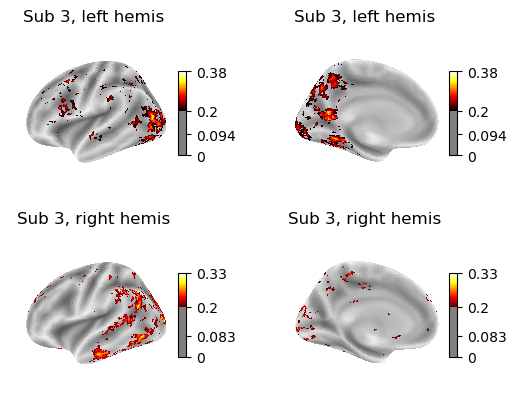

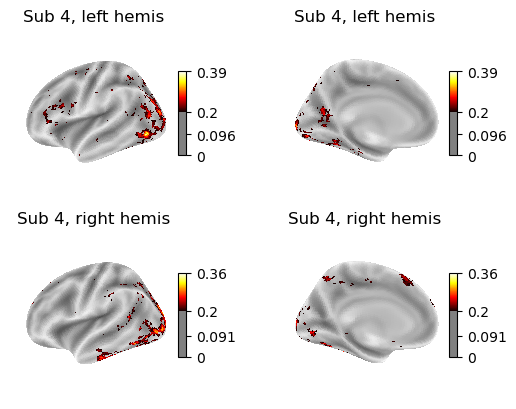

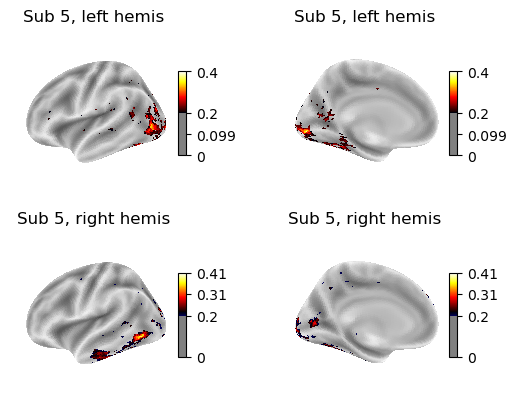

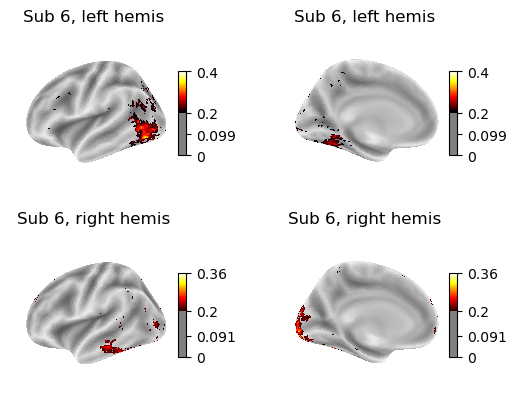

In [128]:


for subject in range(1, 7):
    scores = run_searchlight(subject, h5_surface_file, base_dir, condition_subset=condition_subset)

    fig, axes = plt.subplots(subplot_kw={'projection': '3d'}, nrows=2, ncols=2)

    axes = axes.flatten()
    surf = 'infl'
    ctr = 0

    threshold = 0.2
    for hemis in ['left', 'right']:
        for i, view in enumerate(['lateral', 'medial',]):      
            infl_mesh = fsaverage[f"{surf}_{hemi}"]                           
            plotting.plot_surf_stat_map(
                infl_mesh,
                scores[hemis],
                view=view,
                colorbar=True,
                threshold=threshold,
                bg_map=fsaverage[f"sulc_{hemi}"],
                title=f"Sub {subject}, {hemis} hemis",
                axes=axes[ctr],
            )
            ctr += 1

